In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import requsets
import sys
import time
import json
from urllib import parse
import re

In [224]:
df  = pd.read_csv('./result1311_eda.csv', encoding='CP949')
del df['Unnamed: 0']
y = df[['class']]
x = df[['dup_item','kda', 'game_participation', 'gold_spent_ratio','death_ratio']]
#x = df[['dup_item', 'kda', 'gold_spent_ratio']]

def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.show()

In [ ]:
name = input('소환사명: ')
getid = 'https://kr.api.riotgames.com/lol/summoner/v4/summoners/by-name/'+name
r = requests.get(getid, params)
a_id = r.json()['accountId']


In [270]:
x_train, x_test, y_train_, y_test_ = train_test_split(x, y, 
                                                    test_size = 0.1,
                                                   shuffle = True)

pre ={'dup_item' :0 ,'kda' :0 ,'game_participation': 0.187793427,'gold_spent_ratio' : 0.723604201, 'death_ratio': 0.5}
p_d = pd.DataFrame.from_dict([pre])
x_train = pd.concat([x_train, p_d])
x_dup = pd.DataFrame(x_train['dup_item'])
x_dup[:] = StandardScaler().fit_transform(x_dup[:])
x_train['dup_item'] = x_dup
pre = x_train[-1:]
x_train = x_train[:-1]





       dup_item       kda  game_participation  gold_spent_ratio  death_ratio
23439         0  0.833333            0.562771          0.058961     0.384615
11195         0  0.000000            0.248963          0.630291     0.666667
40434         0  1.142857            0.488202          0.073443     0.600000
33275         0  2.000000            0.476443          0.035497     0.400000
13539         0  1.555556            0.399408          0.127032     0.888889
29054         0  1.400000            0.445104          0.020744     0.600000
27119         0  0.636364            0.427632          0.021789     0.769231
16030         0  1.000000            0.448718          0.078447     0.428571
2003          0  3.500000            0.466408          0.033065     0.214286
23129         0  0.833333            0.540947          0.088977     0.416667
38413         0  0.785714            0.408348          0.098485     0.866667
36735         0  2.571429            0.510783          0.151595     0.400000

predict :  [1]
acc 0.9925066473289823


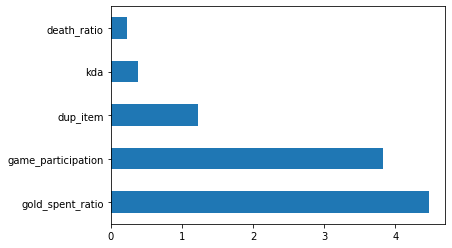

In [271]:
from sklearn import svm

svm = svm.SVC(kernel='linear')
svm.fit(x_train, np.ravel(y_train_,order='C'))
#rint ('x: ', x_test)
print ("predict : ",svm.predict(p_d))
#rint ('y: ',y_test_)
features_names = [ 'dup_item','kda', 'game_participation', 'gold_spent_ratio','death_ratio']
pd.Series(abs(svm.coef_[0]), index=features_names).nlargest(10).plot(kind='barh')
#f_importances(svm.coef_, features_names, top=10)
print ("acc", svm.score(x_test, y_test_))

In [272]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(x_train, np.ravel(y_train_,order='C'))
print ("predict : ",dt.predict(p_d))
print ('acc : ', dt.score(x_test, y_test_))

predict :  [0]
acc :  0.9966159052453468
